## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import datetime
import itertools
from collections import defaultdict

import math
import numpy as np
import pandas as pd
from scipy.stats import shapiro
import scipy.stats as stats
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, KFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error, make_scorer
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.compose import make_column_selector as selector

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV, ElasticNet
from xgboost import XGBRegressor
import catboost as cb
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Configurations

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

## Load Data

In [3]:
dir_path = '/kaggle/input/h-and-m-personalized-fashion-recommendations/'

artcls_df = pd.read_csv(dir_path + 'articles.csv')
cust_df = pd.read_csv(dir_path + 'customers.csv')
trnsctns_df = pd.read_csv(dir_path + 'transactions_train.csv')

In [4]:
artcls_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [5]:
cust_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.00,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.00,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.00,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.00,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.00,1.00,ACTIVE,Regularly,52.00,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [6]:
trnsctns_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.05,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.03,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.02,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.02,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.02,2


## Data Pre-processing

In [7]:
print(f'Minimum date in transaction dataset: {trnsctns_df["t_dat"].min()}')
print(f'Maximum date in transaction dataset: {trnsctns_df["t_dat"].max()}')

Minimum date in transaction dataset: 2018-09-20
Maximum date in transaction dataset: 2020-09-22


#### Handle Missing Values

In [8]:
cust_df['FN'] = cust_df['FN'].fillna(0)
cust_df['Active'] = cust_df['Active'].fillna(0)
cust_df['club_member_status'] = cust_df['club_member_status'].fillna('NOT A MEMBER')
cust_df['Active'] = cust_df['Active'].fillna('NONE')
cust_df['age'] = cust_df['age'].fillna(cust_df['age'].median())

#### Convert Data Types

In [9]:
trnsctns_df['sales_channel_id'] = trnsctns_df['sales_channel_id'].astype('category')

## Data Preparation

In [10]:
mergd_df = trnsctns_df.merge(artcls_df.drop(columns=['detail_desc']), on='article_id', how='left')
mergd_df = mergd_df.merge(cust_df.drop(columns=['postal_code']), on='customer_id', how='left')

mergd_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,FN,Active,club_member_status,fashion_news_frequency,age
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.05,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1338,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear",0.00,0.00,ACTIVE,NONE,24.00
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.03,2,541518,Rae Push (Melbourne) 2p,306,Bra,Underwear,1010016,Solid,51,Light Pink,1,Dusty Light,4,Pink,1334,Casual Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear",0.00,0.00,ACTIVE,NONE,24.00
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.02,2,505221,Inca Jumper,252,Sweater,Garment Upper body,1010010,Melange,52,Pink,2,Medium Dusty,4,Pink,5963,Tops Knitwear DS,D,Divided,2,Divided,58,Divided Selected,1003,Knitwear,1.00,1.00,ACTIVE,Regularly,32.00
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.02,2,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,1010010,Melange,52,Pink,7,Medium,4,Pink,3090,Campaigns,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,1.00,1.00,ACTIVE,Regularly,32.00
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.02,2,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,1010010,Melange,93,Dark Green,4,Dark,19,Green,3090,Campaigns,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,1.00,1.00,ACTIVE,Regularly,32.00


In [11]:
print(f"articles: {artcls_df.shape}")
print(f"customers: {cust_df.shape}")
print(f"transactions: {trnsctns_df.shape}")
print(f"master dataset: {mergd_df.shape}")

articles: (105542, 25)
customers: (1371980, 7)
transactions: (31788324, 5)
master dataset: (31788324, 33)


In [12]:
del trnsctns_df

## More Data Pre-processing

#### Change 't_dat' column type

In [13]:
mergd_df['t_dat'] = pd.to_datetime(mergd_df['t_dat'], format = "%Y-%m-%d")

#### Check if any date is missing in the merged dataset during the reporting period

In [14]:
strt_dt = mergd_df['t_dat'].min()
end_dt = mergd_df['t_dat'].max()
dt_rnge = pd.date_range(start=strt_dt, end=end_dt)
missing_dts = dt_rnge.difference(mergd_df['t_dat'])

print(f"Missing dates in merged dataset: {missing_dts}")

Missing dates in merged dataset: DatetimeIndex([], dtype='datetime64[ns]', freq=None)


#### Pick the top-5 articles that had the highest sales during the reporting period and forecast sales

In [15]:
top5_article_sales = mergd_df.groupby(['article_id']).agg({'price': ['count', 'sum']})

# Flatten the multi-level column index
#top5_article_sales.columns = ['_'.join(col).strip() for col in top5_article_sales.columns.values]
top5_article_sales.columns = ['quantity', 'sales']

# Sort by quantity in descending order
top5_article_sales = top5_article_sales.sort_values(by='quantity', ascending=False)

top5_article_sales.head()

,quantity,sales
article_id,,
706016001,50287,1631.73
706016002,35043,1136.32
372860001,31718,411.00
610776002,30199,244.10
759871002,26329,147.58


In [16]:
# Sort by sales in descending order
top5_article_sales.sort_values(by='sales', ascending=False).head()

,quantity,sales
article_id,,
706016001,50287,1631.73
706016002,35043,1136.32
568601006,19379,939.27
448509014,19216,781.48
706016003,21241,692.20


#### Check the metadata of top-5 articles that reported the highest sales

In [17]:
artcls_df[artcls_df['article_id'].isin([706016001, 706016002, 568601006, 448509014, 706016003])]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
3091,448509014,448509,Perrie Slim Mom Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,72,Blue,3,Light,2,Blue,1747,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,"5-pocket, ankle-length jeans in washed, sturdy..."
16003,568601006,568601,Mariette Blazer,264,Blazer,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1212,Suit,A,Ladieswear,1,Ladieswear,11,Womens Tailoring,1008,Dressed,Fitted jacket in woven fabric with notch lapel...
53892,706016001,706016,Jade HW Skinny Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,9,Black,4,Dark,5,Black,1747,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,High-waisted jeans in washed superstretch deni...
53893,706016002,706016,Jade HW Skinny Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,71,Light Blue,3,Light,2,Blue,1747,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,High-waisted jeans in washed superstretch deni...
53894,706016003,706016,Jade HW Skinny Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,73,Dark Blue,2,Medium Dusty,2,Blue,1747,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,High-waisted jeans in washed superstretch deni...


#### Aggregate sales for those articles

In [18]:
agg_sales_top5_articles = mergd_df[mergd_df['article_id'].isin([706016001, 706016002, 568601006, 448509014, 706016003])].\
                                groupby(['t_dat', 'article_id'])['price'].sum().reset_index()
agg_sales_top5_articles.rename(columns={'price': 'sales'}, inplace=True)

agg_sales_top5_articles.head()

,t_dat,article_id,sales
0,2018-09-20,448509014,0.75
1,2018-09-20,568601006,2.34
2,2018-09-21,448509014,0.89
3,2018-09-21,568601006,2.29
4,2018-09-22,448509014,0.13


#### Create a multi-index variable

In [19]:
multi_index = pd.MultiIndex.from_product([pd.date_range(strt_dt, end_dt),
                                          agg_sales_top5_articles.article_id.unique()],
                                         names=['t_dat','article_id'],)
agg_sales_top5_articles = agg_sales_top5_articles.set_index(['t_dat','article_id']).reindex(multi_index).reset_index()

agg_sales_top5_articles.head()

,t_dat,article_id,sales
0,2018-09-20,448509014,0.75
1,2018-09-20,568601006,2.34
2,2018-09-20,706016002,NaN
3,2018-09-20,706016001,NaN
4,2018-09-20,706016003,NaN


#### Fill missing values with 0s

In [20]:
agg_sales_top5_articles[['sales']] = agg_sales_top5_articles[['sales']].fillna(0.00)
agg_sales_top5_articles.head()

,t_dat,article_id,sales
0,2018-09-20,448509014,0.75
1,2018-09-20,568601006,2.34
2,2018-09-20,706016002,0.00
3,2018-09-20,706016001,0.00
4,2018-09-20,706016003,0.00


## Feature Engineering

Function for adding lag features

In [21]:
def lag_features(df, lags):
    for lag in lags:
        df[f"sales_t-{lag}"] = df.groupby(["article_id"])["sales"].transform(lambda x: x.shift(lag))
    return df

Function for rolling average features

In [22]:
# Random Noise
def random_noise(df):
    return np.random.normal(scale=2.0, size=(len(df),))

In [23]:
def roll_mean_features(df, windows):
    for window in windows:
        df['sales_roll_mean_' + str(window)] = df.groupby(["article_id"])['sales']. \
                                                          transform(
            lambda x: x.shift(16).rolling(window=window, min_periods=7, win_type="triang").mean()) + random_noise(df)
    return df

Exponential Weighted Moving Average (EWM) Features

In [24]:
def ewm_features(df, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            df['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                df.groupby(["article_id"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return df

Add new columns that provide temporal information about the data

In [25]:
def create_date_features(df):
    df['month'] = df.t_dat.dt.month
    df['day_of_month'] = df.t_dat.dt.day
    df['day_of_year'] = df.t_dat.dt.dayofyear
    df['day_of_week'] = df.t_dat.dt.dayofweek
    df['year'] = df.t_dat.dt.year
    return df

In [32]:
agg_sales_top5_articles = agg_sales_top5_articles.sort_values(by=['t_dat', 'article_id'], ascending=[True, True])

data = create_date_features(agg_sales_top5_articles)
data = lag_features(data, lags = [*range(1, 16), 16,17,18,19,20,21,22,30,31,90,180,364])
data = roll_mean_features(data,[16,17,18,30])
data = ewm_features(data, [0.95, 0.9, 0.8, 0.5],[1, 7,30])

data.head(20)

,t_dat,article_id,sales,month,day_of_month,day_of_year,day_of_week,year,sales_t-1,sales_t-2,sales_t-3,sales_t-4,sales_t-5,sales_t-6,sales_t-7,sales_t-8,sales_t-9,sales_t-10,sales_t-11,sales_t-12,sales_t-13,sales_t-14,sales_t-15,sales_t-16,sales_t-17,sales_t-18,sales_t-19,sales_t-20,sales_t-21,sales_t-22,sales_t-30,sales_t-31,sales_t-90,sales_t-180,sales_t-364,sales_roll_mean_16,sales_roll_mean_17,sales_roll_mean_18,sales_roll_mean_30,sales_ewm_alpha_095_lag_1,sales_ewm_alpha_095_lag_7,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_09_lag_1,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_30
0,2018-09-20,448509014,0.75,9,20,263,3,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-09-20,568601006,2.34,9,20,263,3,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-09-20,706016001,0.00,9,20,263,3,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-09-20,706016002,0.00,9,20,263,3,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-09-20,706016003,0.00,9,20,263,3,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-09-21,448509014,0.89,9,21,264,4,2018,0.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.75,NaN,NaN,0.75,NaN,NaN,0.75,NaN,NaN,0.75,NaN,NaN
6,2018-09-21,568601006,2.29,9,21,264,4,2018,2.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.34,NaN,NaN,2.34,NaN,NaN,2.34,NaN,NaN,2.34,NaN,NaN
8,2018-09-21,706016001,0.00,9,21,264,4,2018,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN
7,2018-09-21,706016002,0.00,9,21,264,4,2018,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN
9,2018-09-21,706016003,0.00,9,21,264,4,2018,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN


In [33]:
categorical_features = ['article_id']

data[categorical_features] = data[categorical_features].astype('category')

## Split the data

In [52]:
data = data.query("t_dat > '2018-09-20'")

X = data.query("t_dat < '2020-09-01'")
X.drop(['t_dat'], inplace=True, axis=1)
Y = X['sales']
X = X.drop(['sales', 'year'], axis=1)

X_test = data.query("t_dat >= '2020-09-01'")
X_test.drop(['t_dat', 'year'], inplace=True, axis=1)
Y_test = X_test['sales']
X_test = X_test.drop(['sales'], axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"Y_val: {Y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"Y_test: {Y_test.shape}")

X_train: (2844, 48)
Y_train: (2844,)
X_val: (711, 48)
Y_val: (711,)
X_test: (110, 48)
Y_test: (110,)


## Model Training

In [53]:
final_features = X_train.columns.to_list()

### Light GBM Regressor

In [54]:
lgb_params = {
    'metric': 'mse',
    'boosting_type' : 'gbdt',
    'num_leaves': 8,
    'learning_rate': 0.2,
    'max_depth': 7,
    'verbose': 0,
    'num_boost_round': 5000,
    'early_stopping_rounds': 200,
    'nthread': -1,
    'force_col_wise': True,
    'device_type': 'cpu',
}

train_dataset = lgb.Dataset(data=X_train, label=Y_train,
                            feature_name=final_features, categorical_feature=categorical_features)
val_dataset = lgb.Dataset(data=X_val, label=Y_val, reference=train_dataset,
                          feature_name=final_features, categorical_feature=categorical_features)

model_lgb = lgb.train(
    params=lgb_params, 
    train_set=train_dataset,
    valid_sets=[train_dataset, val_dataset],
    verbose_eval=100,
)

Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.256212	valid_1's l2: 0.568545
[200]	training's l2: 0.128097	valid_1's l2: 0.540349
[300]	training's l2: 0.0694984	valid_1's l2: 0.533883
[400]	training's l2: 0.0410517	valid_1's l2: 0.53592
[500]	training's l2: 0.0248522	valid_1's l2: 0.538766
Early stopping, best iteration is:
[334]	training's l2: 0.0579215	valid_1's l2: 0.532879


## Model Evaluation

In [55]:
def recursive_predict(model):
    global X_test
    output = np.array([])
    for day in range(1, 23):
        pred = model.predict(X_test.query(f"day_of_month == {day}"))
        pred[pred < 0] = 0
        output = np.concatenate([output, pred], axis=0)
        for k in range(day+1, 23):
            X_test.loc[X_test[X_test["day_of_month"] == k].index, f"sales_t-{k-day}"] = pred
    return output

In [56]:
# Metrics used to evaluate models
def metrics_regression(y_true, y_pred, dataset='Validation'):
    # MSE
    mse = mean_squared_error(y_true, y_pred) #!
    
    # RMSE (Root Mean Square Error)
    rmse = math.sqrt(mse)
    
    # R^2
    r2 = r2_score(y_true, y_pred)
    
    # MAE(mean absolute error)
    mae = mean_absolute_error(y_true, y_pred) #!
    
    # MAPE(mean absolute percentage error)
    mape = mean_absolute_percentage_error(y_true, y_pred) #!
    
    #SMAPE (symmetric mean absolute percentage error)
    smape = 1/len(y_true) * np.sum(2 * np.abs(y_pred-y_true) / (np.abs(y_true) + np.abs(y_pred))*100)
    
    header = f"{dataset} Set Performance"
    print("="*len(header), '\n', header, '\n', "="*len(header))
    print(f"MSLE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"SMAPE: {smape:.4f}")

#### LightGBM Regressor

In [57]:
Y_val_pred_lgb = model_lgb.predict(X_val, num_iteration=model_lgb.best_iteration)
Y_test_pred_lgb = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)
Y_val_pred_lgb[Y_val_pred_lgb < 0] = 0

metrics_regression(Y_test, Y_test_pred_lgb, dataset='Validation')

rec_pred_lgb = recursive_predict(model_lgb)

 Validation Set Performance 
MSLE: 0.6517
RMSE: 0.8073
R2: 0.4017
MAE: 0.6166
MAPE: 0.4025
SMAPE: 34.3850


## Plot sales forecasting

In [58]:
test_data_df = data.query("t_dat >= '2020-09-01'")
test_data_df['sales_pred'] = Y_test_pred_lgb
test_data_df.head()

,t_dat,article_id,sales,month,day_of_month,day_of_year,day_of_week,year,sales_t-1,sales_t-2,sales_t-3,sales_t-4,sales_t-5,sales_t-6,sales_t-7,sales_t-8,sales_t-9,sales_t-10,sales_t-11,sales_t-12,sales_t-13,sales_t-14,sales_t-15,sales_t-16,sales_t-17,sales_t-18,sales_t-19,sales_t-20,sales_t-21,sales_t-22,sales_t-30,sales_t-31,sales_t-90,sales_t-180,sales_t-364,sales_roll_mean_16,sales_roll_mean_17,sales_roll_mean_18,sales_roll_mean_30,sales_ewm_alpha_095_lag_1,sales_ewm_alpha_095_lag_7,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_09_lag_1,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_30,sales_pred
3560,2020-09-01,448509014,1.30,9,1,245,1,2020,1.82,1.03,1.45,1.54,1.80,3.30,3.43,2.16,1.78,1.38,2.04,2.56,2.18,2.43,1.07,1.53,1.51,1.35,1.99,4.08,1.63,1.56,0.43,0.52,0.36,1.93,1.88,3.48,3.26,0.46,4.17,1.79,3.37,0.43,1.75,3.30,0.44,1.68,3.16,0.45,1.60,2.70,0.59,1.43
3561,2020-09-01,568601006,1.81,9,1,245,1,2020,2.32,1.44,1.68,1.80,2.30,2.03,1.92,0.95,0.71,0.63,1.21,1.40,0.79,0.90,1.15,1.19,0.78,0.49,0.43,1.38,0.55,0.24,0.45,0.59,0.20,0.55,2.35,-0.76,1.15,0.71,3.52,2.27,1.87,0.46,2.23,1.82,0.46,2.15,1.72,0.47,1.97,1.40,0.50,2.21
3563,2020-09-01,706016001,3.48,9,1,245,1,2020,2.93,3.33,2.50,2.83,3.21,4.97,4.44,3.86,2.74,2.32,1.34,2.01,2.42,2.33,2.28,1.22,1.06,1.32,1.33,2.41,1.07,1.22,1.28,1.87,1.40,3.82,3.09,0.96,1.41,0.71,2.41,2.95,4.41,1.30,2.96,4.37,1.33,2.98,4.27,1.38,3.02,3.78,1.57,2.83
3562,2020-09-01,706016002,0.61,9,1,245,1,2020,0.60,0.93,1.26,0.95,0.93,0.90,1.00,0.71,0.57,0.72,0.40,0.53,0.54,0.82,0.69,0.20,0.36,0.33,0.44,0.51,0.53,0.27,1.86,1.54,1.06,1.89,2.02,0.33,-2.09,-0.96,4.35,0.61,0.99,1.84,0.63,0.97,1.83,0.67,0.94,1.80,0.80,0.83,1.85,0.99
3564,2020-09-01,706016003,1.11,9,1,245,1,2020,1.30,0.30,1.13,1.18,1.71,3.59,2.95,3.39,2.94,1.68,1.57,1.57,1.97,2.39,2.06,1.32,0.81,1.17,1.12,3.18,1.34,1.57,0.95,0.60,0.22,1.81,0.80,-0.57,0.77,1.78,3.62,1.26,2.97,0.94,1.21,2.99,0.92,1.14,3.01,0.90,1.10,2.90,0.97,1.38


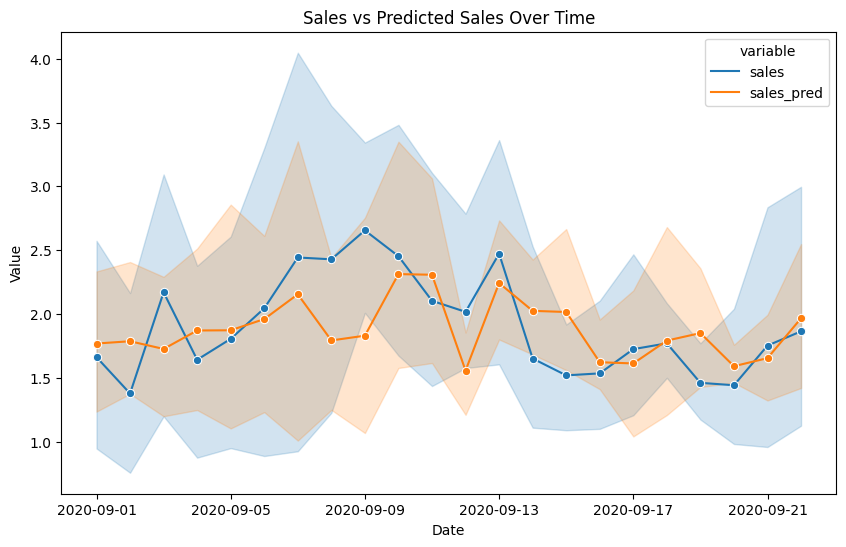

In [59]:
# Melt the DataFrame to long format for easy plotting
df_long = pd.melt(test_data_df[['t_dat', 'sales', 'sales_pred']], id_vars='t_dat', var_name='variable', value_name='value')

# Create a line plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='t_dat', y='value', hue='variable', data=df_long, marker='o')

plt.title('Sales vs Predicted Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()